In [1]:
import torch.nn as nn
import torch
from torch import optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


import pywt
from pywt._doc_utils import draw_2d_wp_basis, wavedec2_keys

In [2]:
def get_im_decomp(image, nlevel = 1):
    '''
    IN: RGB image of shape [3, n, n]; torch tensor format
    OUT: RGB n-level decomp of the image of shape [3, n, n]; torch tensor format
    
    Splits the image into its constituent colour channels, then finds the n-level 2d wavelet decomp
    for each, formats that data as required and stacks the colour channels again.
    '''
    image = torch.Tensor.numpy(image)
    
    image_r_init = np.asarray(image[0, :, :])
    image_g_init = np.asarray(image[1, :, :])
    image_b_init = np.asarray(image[2, :, :])

    # Finds channelwise n-level wavelet decomp 
    image_r = pywt.wavedec2(image_r_init, 'db2', mode = 'periodization',  level = nlevel)
    image_g = pywt.wavedec2(image_g_init, 'db2', mode = 'periodization',  level = nlevel)
    image_b = pywt.wavedec2(image_b_init, 'db2', mode = 'periodization',  level = nlevel)

    # Rearranges the channels back into image form
    image_decomp_r, waste = pywt.coeffs_to_array(image_r)
    image_decomp_g, waste = pywt.coeffs_to_array(image_g)
    image_decomp_b, waste = pywt.coeffs_to_array(image_b)

    # Reassembles the channels into an RGB image
    image_decomp = [image_decomp_r, image_decomp_g, image_decomp_b]
    image_decomp_final = np.zeros((3, 64, 64))
    for channel in range(3):
        image_decomp_final[channel, :, :] = image_decomp[channel]

    image_decomp_final = torch.from_numpy(image_decomp_final).float()

    return image_decomp_final

In [7]:
batch_size = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((64, 64)),
     transforms.Lambda(lambda X: get_im_decomp(X, 2))]) # Only works if num_workers = 0.
                                                        # python’s multiprocessing library attempts to pickle objects to share them between
                                                        # processes, but lambda functions cannot be pickled and custom torch transforms MUST be
                                                        # lambda function. This will slow data loading, but... I mean shit, training is already
                                                        # an overnight job.

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
s = 2

class NoWaveNet(nn.Module):
    def __init__(self):
        super(NoWaveNet, self).__init__()

        # Activation function
        self.relu = nn.ReLU(inplace = True)

        self.projection1 = nn.Conv2d(in_channels = 3, out_channels = 64*s, kernel_size = 1, stride = 2)

        # First two convolutional layers
        self.convk11 = nn.Conv2d(in_channels = 3, out_channels = 16*s, kernel_size = 3, padding = 1)
        self.convk12 = nn.Conv2d(in_channels = 16*s, out_channels = 16*s, kernel_size = 3, padding = 1, stride = 2)

        # Second pair of convolutional layers
        self.convk21 = nn.Conv2d(in_channels = 80*s, out_channels = 24*s, kernel_size = 3, padding = 1)
        self.convk22 = nn.Conv2d(in_channels = 24*s, out_channels = 24*s, kernel_size = 3, padding = 1)

        # Second projection shortcut
        self.projection2 = nn.Conv2d(in_channels = 80*s, out_channels = 96*s, kernel_size = 1)

        # Third pair of convolutional layers
        self.convk31 = nn.Conv2d(in_channels = 120*s, out_channels = 64*s, kernel_size = 3, padding = 1)
        self.convk32 = nn.Conv2d(in_channels = 64*s, out_channels = 48*s, kernel_size = 3, padding = 1) #as above

        # Third projection shortcut
        self.projection3 = nn.Conv2d(in_channels = 120*s, out_channels = 128*s, kernel_size = 1) #as above


        # Average pooling layer to trim parameters and allow a tractible output layer
        self.avgpool = nn.AvgPool2d(kernel_size = 10)

        # Fully connected output layer
        self.output = nn.Linear(3168, 10)


    def forward(self, x):
        shortcut_1 = self.relu(self.projection1(x))
        x = self.relu(self.convk11(x))
        x = self.relu(self.convk12(x))

        x = torch.cat((x, shortcut_1), 1)
        
        shortcut_2 = self.relu(self.projection2(x))
        x = self.relu(self.convk21(x))
        x = self.relu(self.convk22(x))

        x = torch.cat((x, shortcut_2), 1)
        
        shortcut_3 = self.relu(self.projection3(x))
        x = self.relu(self.convk31(x))
        x = self.relu(self.convk32(x))

        x = torch.cat((x, shortcut_3), 1)

        x = self.avgpool(x)
        x = x.reshape([-1, 3168])
        x = self.output(x)
        return (x)

NoWave = NoWaveNet()
print(NoWave); total_params = sum(p.numel() for p in NoWave.parameters())
print(f"Number of parameters: {total_params}")

NoWaveNet(
  (relu): ReLU(inplace=True)
  (projection1): Conv2d(3, 128, kernel_size=(1, 1), stride=(2, 2))
  (convk11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convk12): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (convk21): Conv2d(160, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convk22): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (projection2): Conv2d(160, 192, kernel_size=(1, 1), stride=(1, 1))
  (convk31): Conv2d(240, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convk32): Conv2d(128, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (projection3): Conv2d(240, 256, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=10, stride=10, padding=0)
  (output): Linear(in_features=3168, out_features=10, bias=True)
)
Number of parameters: 612202


Epoch 18/50 Summary
Training Loss: 0.277, Training Accuracy: 0.901
Validation Loss: 0.934, Validation Accuracy: 0.739


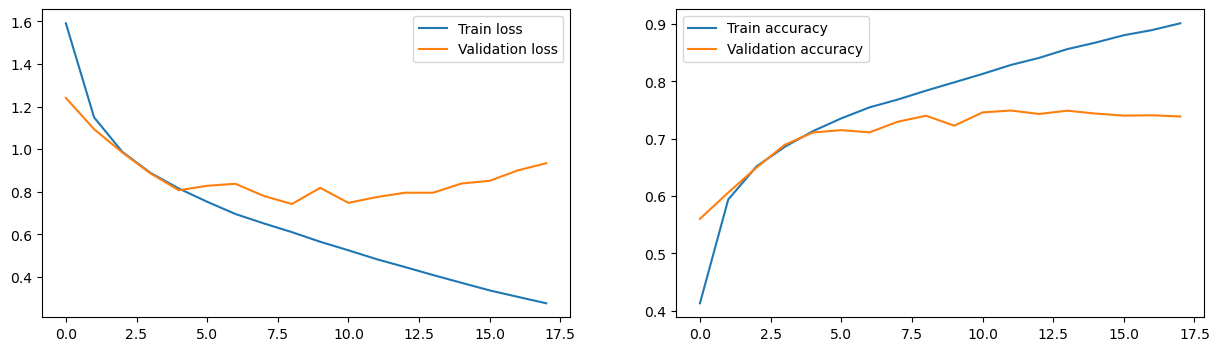

Best validation accuracy: 0.749
Early stopping triggered.
Training time:  1748.0716135501862


In [25]:
from IPython.display import clear_output
from torch import optim
import time

t0 = time.time()

# Trains on CUDA GPU if possible; it is on my laptop and I don't wanna wait a trillion years to train
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
NoWave.to(device)
NoWave.train() 
print_interval = 25
debug = False

# Instantiating variables
top_val_acc = 0
loss = nn.CrossEntropyLoss()
min_val_loss = np.inf
optimiser = torch.optim.Adam(NoWave.parameters(), lr = 0.0005)
n_epochs = 50
train_losses_list, val_losses_list, train_acc_list, val_acc_list = [], [], [], []

for n in range(n_epochs):
    # Tracking metrics for this epoch
    tot_train_loss = 0
    train_correct = 0 

    # Training loop
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        
        model_pred = NoWave(X)
        loss_value = loss(model_pred, y)
        tot_train_loss += loss_value.item() * X.size(0)
        
        loss_value.backward()
        optimiser.step()
        optimiser.zero_grad()

        # Accuracy for this batch
        predicted_class = model_pred.argmax(dim = 1)
        train_correct += (predicted_class == y).float().sum().item()

        # Print progress every `print_interval` batches
        if (batch_idx + 1) % print_interval == 0 or (batch_idx + 1) == len(train_loader):
            print(f"Epoch: {n+1}/{n_epochs}, Training Batch: {batch_idx+1}/{len(train_loader)}")

    # Validation loop
    tot_val_loss = 0
    val_correct = 0  

    with torch.no_grad():
        NoWave.eval()
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            
            model_pred = NoWave(X)
            loss_value = loss(model_pred, y)
            tot_val_loss += loss_value.item() * X.size(0)

            # This is kind of hacky, but since argmax will only ever mark one predicted class
            # increases the counter if the CNN classifies correctly
            predicted_class = model_pred.argmax(dim = 1)
            val_correct += (predicted_class == y).float().sum().item()
        NoWave.train()

    # Epoch statistics
    train_loss = tot_train_loss / len(train_loader.dataset)
    val_loss = tot_val_loss / len(test_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    # Append metrics for plotting
    train_losses_list.append(train_loss)
    val_losses_list.append(val_loss)
    train_acc_list.append(train_accuracy)
    val_acc_list.append(val_accuracy)

    # Checkpoint if validation accuracy increases
    if val_accuracy > top_val_acc:
        torch.save(NoWave, 'first_wave_model_initial.model') # Save
        top_val_acc = val_accuracy
        count = 0
    else:
        count += 1

    # Clear output once per epoch and display epoch summary and plots
    clear_output(wait=True)
    print(f"Epoch {n+1}/{n_epochs} Summary")
    print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
    print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

    # Plotting after each epoch
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    plt.plot(train_losses_list, label = 'Train loss')
    plt.plot(val_losses_list, label = 'Validation loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(train_acc_list, label = 'Train accuracy')
    plt.plot(val_acc_list, label = 'Validation accuracy')
    plt.legend()
    plt.show()

    print(f"Best validation accuracy: {top_val_acc:.3f}")

    # Early stopping
    if count == 6:
        print("Early stopping triggered.")
        t1 = time.time()
        total = t1-t0
        print("Training time: ", total)
        break